<a href="https://colab.research.google.com/github/wlr2678/ChangE_4_data_playground/blob/master/first_glance_own_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Install a pip package in the current Jupyter kernel
import sys
pip install pds4_tools
pip install matplotlib
pip install numpy
pip install Pillow
pip install colour-science
pip install colour-demosaicing

SyntaxError: invalid syntax (<ipython-input-21-91b4577ffae8>, line 3)

In [23]:
from pds4_tools import pds4_read       # to read and inspect the data and metadata
import matplotlib.pyplot as plt        # for plotting
import matplotlib
import numpy as np
from PIL import Image

import cv2 as cv # HDR tonemapping trial

# for plotting in Jupyter notebooks
# %matplotlib notebook
# for plotting in Google Colab, inline with the cell outputs
# %matplotlib inline

from skimage import exposure
from skimage import data, img_as_float
import colour
from colour.plotting import *
import glob, os # for batch reading, processing and exporting in directories

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_Menon2007,
    mosaicing_CFA_Bayer)

cctf_encoding = colour.cctf_encoding
_ = colour.utilities.filter_warnings()
# colour.utilities.describe_environment();

def read_pds(path):
    data = pds4_read(path, quiet=True)
    img = np.array(data[0].data)
    img = img_as_float(img)
    return img

def debayer_img(img, CFA='RGGB'):
    # Menon2007 yields better edges than bilinear
    debayered = cctf_encoding(demosaicing_CFA_Bayer_Menon2007(img, CFA))
    return debayered

def stretch_img(img, percent=0.5):
    # cf https://www.harrisgeospatial.com/docs/BackgroundStretchTypes.html
    # Adapts for different percentages
    p2, p98 = np.percentile(img, (0+percent, 100-percent))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img

def check_type(p): # Check PCAM image type
    ty = p.split('_')[2].split('-')[1]
    return ty

def plot_img_and_hist(image, ty='Q', size=10,  hist=True, bins=128): # ty indicates the type of the data product
    """Plot an image along with its histogram.
    """
    if hist:
        fig, axes = plt.subplots(2,1, figsize=(size,size), gridspec_kw={'height_ratios': [3, 1]})
        ax_img, ax_hist = axes
    else:
        fig, ax_img = plt.subplots(figsize=(size,size))

    # Display image
    ax_img.imshow(image, cmap='gray')
    # Without axes on image
    ax_img.set_axis_off()

    if hist:
        # Display histogram
        if ty == 'Q': # Panchromatic
          ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
        elif ty == 'C': # Colour
          ax_hist.hist(image[:,:,0].ravel(), bins=bins, histtype='step', color='red')
          ax_hist.hist(image[:,:,1].ravel(), bins=bins, histtype='step', color='green')
          ax_hist.hist(image[:,:,2].ravel(), bins=bins, histtype='step', color='blue')
        else: # Unknown type
          print('Image data type not recognized')
          pass

        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_yticks([])
    
def export_img(name, img):
    pil_img = Image.fromarray(np.uint8(img*255))
    pil_img.save(name)

def preview_save(img, ty, size=10, hist=False):
    print('Generating preview...')
    plot_img_and_hist(img, ty, size, hist)
    plt.show()
    print('Saving image...')
    export_img('{}.png'.format(p), img)

def truncate(filename): # Trim filenames for less cluttered message printouts
    trimmed_name = filename.split('_')[2][0:-4] + '_' + filename.split('_')[5]
    return trimmed_name

In [24]:
directory = 'C:/Users/Darren Wu/Desktop/SpaceInfos/2021/CE4Ro-PCAM\CE4-PCAML-C-2B-2021-02'
os.chdir(directory)
p = []
for filename in glob.glob('*.2BL'):
    p.append(filename)
print('File list loaded.')

File list loaded.


Processing and exporting file 1 PCAML-C_20210207084724 Generating preview...


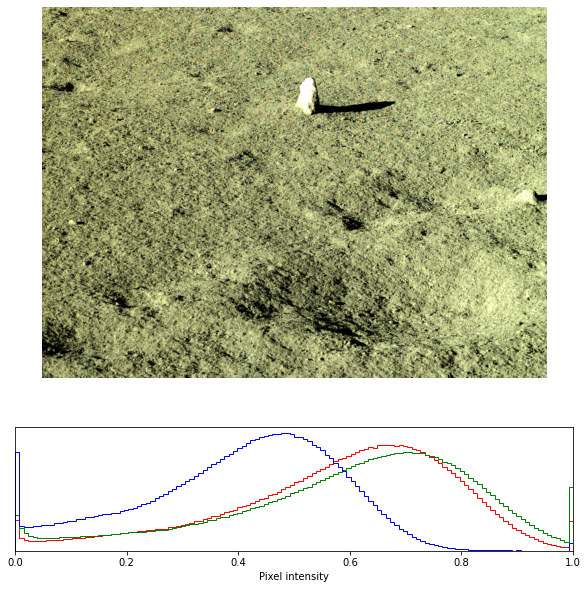

DONE
Processing and exporting file 2 PCAML-C_20210207090358 Generating preview...


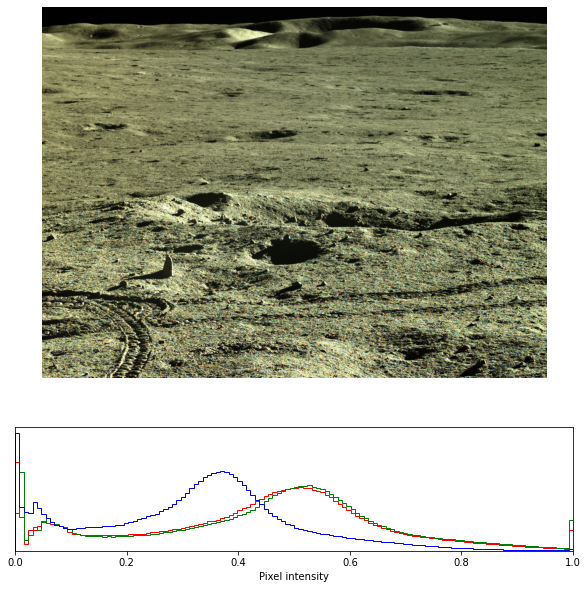

DONE


In [34]:
for filename in p:
    img = read_pds(filename)
    ty = check_type(filename)

    print('Processing and exporting file', p.index(filename)+1, truncate(filename), end=' ')
    
    if ty == 'C':
        img = debayer_img(img)
        img = img.astype('float32')
        tonemap1 = cv.createTonemapMantiuk(gamma=1, scale=1.2, saturation=1)
        img = tonemap1.process(img)

    img = stretch_img(img)
    
    print('Generating preview...')
    plot_img_and_hist(img, ty, 10, True)
    plt.show()
    export_img('{}.png'.format(truncate(filename)), img)
    print('DONE')
    